In [1]:
import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt


Welcome to JupyROOT 6.20/04


In [2]:
sg_file = uproot.open("/data/event/final/sg_10ppwax/Events/run_01/tag_1_delphes_events.root") 
bg_file = uproot.open("/data/event/final/bg_ppaalvll/Events/run_01/tag_1_delphes_events.root")
bg_jet_file = uproot.open("/data/event/final/bgjet_pplvllj/Events/run_01/tag_1_delphes_events.root")

m_ax = 10

sg_Xsection = 14060
bg_Xsection = 94.37
j_Xsection = 5887000

# sg_X  1(15990) 5(15250) 10(14060) 15(12870) 20(11850)  25(10890)
# bg_x  94.37
# j_x   5887000

In [3]:
def file_np(file):
    event = [ file["Delphes;1"]["Electron"].array(),
              file["Delphes;1"]["Electron.PT"].array(),
              file["Delphes;1"]["Electron.Eta"].array(),
              file["Delphes;1"]["Electron.Phi"].array(),
              file["Delphes;1"]["Muon"].array(),                #4
              file["Delphes;1"]["Muon.PT"].array(),
              file["Delphes;1"]["Muon.Eta"].array(),
              file["Delphes;1"]["Muon.Phi"].array(),
              file["Delphes;1"]["Photon"].array(),              #8
              file["Delphes;1"]["Photon.PT"].array(),
              file["Delphes;1"]["Photon.Eta"].array(),
              file["Delphes;1"]["Photon.Phi"].array(),
              file["Delphes;1"]["MissingET"].array(),           #12
              file["Delphes;1"]["MissingET.fUniqueID"].array(),   
              file["Delphes;1"]["MissingET.fBits"].array(),
              file["Delphes;1"]["MissingET.MET"].array(),
              file["Delphes;1"]["MissingET.Eta"].array(),
              file["Delphes;1"]["MissingET.Phi"].array(),
              file["Delphes;1"]["Jet"].array(),                 #18
              file["Delphes;1"]["Jet.EhadOverEem"].array(),     
              file["Delphes;1"]["Jet.Mass"].array(),
              file["Delphes;1"]["Event.Number"].array(),
              file["Delphes;1"]["Jet.Tau[5]"].array()
              ]
    
    event = np.expand_dims(event, axis=-1)    ### reshape data
    event = event.transpose((1,0,2))
    event = np.squeeze(event,axis=(2,))
    return event 

feture=['e_Num', 'e_Pt', 'e_Eta', 'ePhi', 'mu_Num', 'mu_Pt', 'mu_Eta', 'mu_Phi', 'a_Num', 'a_Pt', 'a_Eta', 'a_Phi', 'mis_Num', 'mis_ID', 'mis_Fbit', 'mis_Pt', 'mis_Eta', 'mis_Phi', 'jet_Num', 'jet_EhandoverEem', 'jet_Mass', 'Event_Num', 'jet_Tau5' ]

In [4]:
bg_events = file_np(bg_file)
sg_events = file_np(sg_file)
j_events = file_np(bg_jet_file)

In [5]:
me = 0.000511
mu = 0.10566

max_shift = m_ax*0.1
if m_ax == 1:
    max_u = 2
    max_d = 0.5
else:
    max_u = m_ax + 2*max_shift
    max_d = m_ax - max_shift
################################################
def prlen(events):
    print(len(events))

################################################  simple sel (any=? l=1 j>1)
def num_sl(event,lab,num):
    where1 = np.where(event[:,lab]==num)
    return event[where1]

def l_sl(event):
    where1 = np.where(event[:,0]+event[:,4]==1)
    return event[where1]

def j_sl(event):
    where1 = np.where(event[:,18]>0)
    return(event[where1])  

def Ehover(event,sl_jet):
    where=[]
    for i in range(len(event)):
        if np.min(event[i][19])<0.2:
            where.append(i)
            sl_jet.append(np.min(event[i][19]))
    return event[where]   
        
################################################  maa caculate
def m_aa(events, m, pt1):
    where1=[]   
    for i in range(len(events)):
        p = [0,0,0,0] 
        for j in range(events[i][8]):
            pt = events[i][9][j]   
            eta = events[i][10][j]  
            phi = events[i][11][j]    
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
            p[3] = p[3] + pt*np.sinh(eta)   ### pz
            p[0] = p[0] + np.sqrt( (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )     
        maa = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m.append(maa)
        pTaa = np.sqrt(p[1]**2 + p[2]**2)
        pt1.append(pTaa)
        if 90<maa<110:
            where1.append(i)
    return events[where1]
################################################   pt sl    
def pt_sl(events):
    where1=[]
    for i in range(len(events)):
        p = [0,0,0,0]    
        for j in range(events[i][8]):
            pt = events[i][9][j]    
            eta = events[i][10][j]    
            phi = events[i][11][j]   
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
        pTaa = np.sqrt(p[1]**2 + p[2]**2)    
        if pTaa>50:
              where1.append(i)
    return events[where1]
################################################ mlv caculate
def mvl_sl(events,m):
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 + (pt1*np.sinh(eta1))**2)+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 + (pt2*np.sinh(eta2))**2)
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 + (pt1*np.sinh(eta1))**2)+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 + (pt2*np.sinh(eta2))**2)
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m.append(mlv)
################################################## must 1l events
def MTvl_sl(events,m,pt):
    where1=[]
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2)
            mlv  = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 )
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        
        m.append(mlv)
        pt.append(ptlv)
        if mlv > 58:
            where1.append(i)
    return(events[where1])
##################################################   
def PTvl_sl(events):
    where1=[]
    m=[]
    pt=[]
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2)
            mlv  = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 )
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        m.append(mlv)
        pt.append(ptlv)
        if ptlv > 50:
            where1.append(i)
    return(events[where1])
#######################################################################################

def j_mass(events,j_mass):
    where = []
    for i in range(len(events)):
        where1 = np.where(events[i][19]==np.min(events[i][19]))
        for j in range(len(where1[0])):
            jet_m = events[i][20][where1[0][j]]
            j_mass.append(jet_m)
            where.append(i)  
    c = np.unique(where)
    return events[c]


##################################################
def j_mass_sl(events,j_mass):
    where = []
    for i in range(len(events)):
        where1 = np.where(events[i][19]==np.min(events[i][19]))
        for j in range(len(where1[0])):
            jet_m = events[i][20][where1[0][j]]
            if max_d<jet_m<max_u:
                j_mass.append(jet_m)
                where.append(i)  
    if not where:
        c = []
    else:
        c = np.unique(where)
    return events[c]
#######################################################################################
def draw_tau2overtau1(events,tau2overtau1):
    for i in range(len(events)):
        where1 = np.where(events[i][19]==np.min(events[i][19]))
        for j in range(len(where1[0])):
            tau1 = events[i][22][where1[0][j]][0]
            tau2 = events[i][22][where1[0][j]][1]
            if tau1 != 0 :
                tau2overtau1.append(tau2/tau1)
                
def tau2overtau1_sl(events):
    where = []
    for i in range(len(events)):
        where1 = np.where(events[i][19]==np.min(events[i][19]))
        for j in range(len(where1[0])):
            tau1 = events[i][22][where1[0][j]][0]
            tau2 = events[i][22][where1[0][j]][1]
            if tau1 != 0 :
                if tau2/tau1<0.05:
                    where.append(i)
    return events[where]
                               
            
##################################################        
def phi_v(events,phi_list):
    for i in range(len(events)):
        if events[i][0]==1:
            for j in range(len(events[i][3])):
                phi = (events[i][2][j])
                phi_list.append(phi)
        elif events[i][4]==1:
            for j in range(len(events[i][7])):
                phi = events[i][6][j]
                phi_list.append(phi)  
                
def miss_v(events,phi_list):
    for i in range(len(events)):
        for j in range(len(events[i][16])):
            phi = (events[i][17][j])
            phi_list.append(phi)
##################################################  soon drow [i] hist
def soon_draw(events,num,min1,max1,bin_num):
    list1=[]
    for i in range(len(events)):
        if type(events[i][num])==int:
            list1.append(events[i][num])
        else:
            for j in range(len(events[i][num])):
                list1.append(events[i][num][j])
    bins = np.arange(min1,max1,bin_num)
    plt.hist(list1,bins=bins,histtype='step')
    plt.title(feture[num])
    plt.show
def soon_drawvs(sg_events,bg_events,num,min1,max1,bin_num):
    list1=[]
    list2=[]
    for i in range(len(sg_events)):
        if type(sg_events[i][num])==int:
            list1.append(sg_events[i][num])
        else:
            for j in range(len(sg_events[i][num])):
                list1.append(sg_events[i][num][j])
                
    for i in range(len(bg_events)):
        if type(bg_events[i][num])==int:
            list2.append(bg_events[i][num])
        else:
            for j in range(len(bg_events[i][num])):
                list2.append(bg_events[i][num][j])
                
    bins = np.arange(min1,max1,bin_num)
    plt.hist([list1,list2] , bins=bins, histtype='step', label=['sg','bg'],color=['red','darkblue'])
    plt.title(feture[num])
    plt.legend()
    plt.show()    
    
########################################################################################
def significance(s,b):   ### t = (sigma b)^2
    t = (b*0.05)**2
    g = 2*((s+b)*np.log((s+b)*(b+t)/(b**2+(s+b)*t))-((b**2)/t)*np.log(1+(t*s/(b*(b+t)))))
    return np.sqrt(g)
###################################################
def significance2(s,b):
    return np.sqrt(2*((s+b)*np.log(1+s/b)-s))
###########################################
def z_2(f, left, right, epsilon=1e-12):
    if left >= right:
        return None

    while abs(right - left) > epsilon:
        mid = (left + right) / 2
        f_mid = f(mid,b)-2
        if f_mid == 0:
            return mid
        elif f_mid < 0:
            left = mid
        elif f_mid > 0:
            right = mid

    return (left + right) / 2


In [7]:
jEho_sg_1j_Eho=[]
jEho_bg_1j_Eho=[]
jEho_j_1j_Eho=[]


############################# MT PT
MTv_sgsl_1j_Eho_1l_PT = []
MTv_bgsl_1j_Eho_1l_PT = []
MTv_jsl_1j_Eho_1l_PT = []

PTv_sgsl_1j_Eho_1l_PT = []
PTv_bgsl_1j_Eho_1l_PT = []
PTv_jsl_1j_Eho_1l_PT = []

###################################################sl: 1j -> Eho<0.2 -> 1l
sgsl_1j = j_sl(sg_events)
sgsl_1j_Eho = Ehover(sgsl_1j,jEho_sg_1j_Eho)
sgsl_1j_Eho_1l = l_sl(sgsl_1j_Eho)

bgsl_1j = j_sl(bg_events)
bgsl_1j_Eho = Ehover(bgsl_1j,jEho_bg_1j_Eho)
bgsl_1j_Eho_1l = l_sl(bgsl_1j_Eho)

jsl_1j = j_sl(j_events)
jsl_1j_Eho = Ehover(jsl_1j,jEho_j_1j_Eho)
jsl_1j_Eho_1l = l_sl(jsl_1j_Eho)
####################################################sl: 8<jmass<15  ***************************************************************

sgsl_1j_Eho_1l_PT = PTvl_sl(sgsl_1j_Eho_1l)
bgsl_1j_Eho_1l_PT = PTvl_sl(bgsl_1j_Eho_1l)
jsl_1j_Eho_1l_PT = PTvl_sl(jsl_1j_Eho_1l)

sgsl_1j_Eho_1l_PT_MT = MTvl_sl(sgsl_1j_Eho_1l_PT,MTv_sgsl_1j_Eho_1l_PT,PTv_sgsl_1j_Eho_1l_PT)
bgsl_1j_Eho_1l_PT_MT = MTvl_sl(bgsl_1j_Eho_1l_PT,MTv_bgsl_1j_Eho_1l_PT,PTv_bgsl_1j_Eho_1l_PT)
jsl_1j_Eho_1l_PT_MT = MTvl_sl(jsl_1j_Eho_1l_PT,MTv_jsl_1j_Eho_1l_PT,PTv_jsl_1j_Eho_1l_PT)
####################################################

sgsl_1j_Eho_1l_PT_MT_t21 = tau2overtau1_sl(sgsl_1j_Eho_1l_PT_MT)
bgsl_1j_Eho_1l_PT_MT_t21 = tau2overtau1_sl(bgsl_1j_Eho_1l_PT_MT)
jsl_1j_Eho_1l_PT_MT_t21 = tau2overtau1_sl(jsl_1j_Eho_1l_PT_MT)

####################################################

jmass_sgsl_1j_Eho_1l_PT_MT_t21=[]
jmass_sgsl_1j_Eho_1l_PT_MT_t21=[]
jmass_jsl_1j_Eho_1l_PT_MT_t21=[]

sgsl_1j_Eho_1l_PT_MT_t21_jm = j_mass_sl(sgsl_1j_Eho_1l_PT_MT_t21,jmass_sgsl_1j_Eho_1l_PT_MT_t21)
bgsl_1j_Eho_1l_PT_MT_t21_jm = j_mass_sl(bgsl_1j_Eho_1l_PT_MT_t21,jmass_sgsl_1j_Eho_1l_PT_MT_t21)
jsl_1j_Eho_1l_PT_MT_t21_jm = j_mass_sl(jsl_1j_Eho_1l_PT_MT_t21,jmass_jsl_1j_Eho_1l_PT_MT_t21)
####################################################




def s300(sgsl_event):
    s = sg_Xsection*(len(sgsl_event)/len(sg_events))*300
    return s

def b300(bgsl_event):
    b1 = bg_Xsection*(len(bgsl_event)/len(bg_events))*300
    return b1
    
def j300(jsl_event):
    b2 = j_Xsection*(len(jsl_event)/len(j_events))*300
    return b2



####################################################
print('\033[0;34msg sg_event number :\033[0m',len(sg_events))
print('\033[0;34msg after 1j sl :\033[0m',len(sgsl_1j))
print('\033[0;34msg after 1j,EhadOverEem<0.2 sl :\033[0m',len(sgsl_1j_Eho))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l sl :\033[0m',len(sgsl_1j_Eho_1l))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,PTvl>50 sl :\033[0m',len(sgsl_1j_Eho_1l_PT))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58 sl :\033[0m',len(sgsl_1j_Eho_1l_PT_MT))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05 sl :\033[0m',len(sgsl_1j_Eho_1l_PT_MT_t21))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',len(sgsl_1j_Eho_1l_PT_MT_t21_jm))
print('')
print('\033[0;33mbg sg_event number :\033[0m',len(bg_events))
print('\033[0;33mbg after 1j sl :\033[0m',len(bgsl_1j))
print('\033[0;33mbg after 1j,EhadOverEem<0.2 sl :\033[0m',len(bgsl_1j_Eho))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l sl :\033[0m',len(bgsl_1j_Eho_1l))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,PTvl>50 sl :\033[0m',len(bgsl_1j_Eho_1l_PT))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58 sl :\033[0m',len(bgsl_1j_Eho_1l_PT_MT))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05 sl :\033[0m',len(bgsl_1j_Eho_1l_PT_MT_t21))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',len(bgsl_1j_Eho_1l_PT_MT_t21_jm))
print('')
print('\033[0;32mjet_bg jet_bg_event number :\033[0m',len(j_events))
print('\033[0;32mjet_bg after 1j sl :\033[0m',len(jsl_1j))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2 sl :\033[0m',len(jsl_1j_Eho))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l sl :\033[0m',len(jsl_1j_Eho_1l))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,PTvl>50 sl :\033[0m',len(jsl_1j_Eho_1l_PT))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58 sl :\033[0m',len(jsl_1j_Eho_1l_PT_MT))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05 sl :\033[0m',len(jsl_1j_Eho_1l_PT_MT_t21))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',len(jsl_1j_Eho_1l_PT_MT_t21_jm))
print('')
####################################################
print('\033[0;34msg sg_event number :\033[0m',s300(sg_events))
print('\033[0;34msg after 1j sl :\033[0m',s300(sgsl_1j))
print('\033[0;34msg after 1j,EhadOverEem<0.2 sl :\033[0m',s300(sgsl_1j_Eho))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l sl :\033[0m',s300(sgsl_1j_Eho_1l))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,PTvl>50 sl :\033[0m',s300(sgsl_1j_Eho_1l_PT))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58 sl :\033[0m',s300(sgsl_1j_Eho_1l_PT_MT))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05 sl :\033[0m',s300(sgsl_1j_Eho_1l_PT_MT_t21))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',s300(sgsl_1j_Eho_1l_PT_MT_t21_jm))
print('')
print('\033[0;33mbg sg_event number :\033[0m',b300(bg_events))
print('\033[0;33mbg after 1j sl :\033[0m',b300(bgsl_1j))
print('\033[0;33mbg after 1j,EhadOverEem<0.2 sl :\033[0m',b300(bgsl_1j_Eho))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l sl :\033[0m',b300(bgsl_1j_Eho_1l))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,PTvl>50 sl :\033[0m',b300(bgsl_1j_Eho_1l_PT))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58 sl :\033[0m',b300(bgsl_1j_Eho_1l_PT_MT))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05 sl :\033[0m',b300(bgsl_1j_Eho_1l_PT_MT_t21))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',b300(bgsl_1j_Eho_1l_PT_MT_t21_jm))
print('')
print('\033[0;32mjet_bg jet_bg_event number :\033[0m',j300(j_events))
print('\033[0;32mjet_bg after 1j sl :\033[0m',j300(jsl_1j))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2 sl :\033[0m',j300(jsl_1j_Eho))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l sl :\033[0m',j300(jsl_1j_Eho_1l))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,PTvl>50 sl :\033[0m',j300(jsl_1j_Eho_1l_PT))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58 sl :\033[0m',j300(jsl_1j_Eho_1l_PT_MT))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05 sl :\033[0m',j300(jsl_1j_Eho_1l_PT_MT_t21))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',j300(jsl_1j_Eho_1l_PT_MT_t21_jm))


sg sg_event number : 10000
sg after 1j sl : 7799
sg after 1j,EhadOverEem<0.2 sl : 6596
sg after 1j,EhadOverEem<0.2,1l sl : 3349
sg after 1j,EhadOverEem<0.2,1l,PTvl>50 sl : 2734
sg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58 sl : 1702
sg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05 sl : 1252
sg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05 9.0 <jmass< 12.0  sl : 1020

bg sg_event number : 100000
bg after 1j sl : 47385
bg after 1j,EhadOverEem<0.2 sl : 24105
bg after 1j,EhadOverEem<0.2,1l sl : 7896
bg after 1j,EhadOverEem<0.2,1l,PTvl>50 sl : 1442
bg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58 sl : 701
bg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05 sl : 175
bg after 1j,EhadOverEem<0.2,1l,PTvl>50,MTvl>58,tau2/tau1<0.05 9.0 <jmass< 12.0  sl : 3

jet_bg jet_bg_event number : 100000
jet_bg after 1j sl : 83279
jet_bg after 1j,EhadOverEem<0.2 sl : 14256
jet_bg after 1j,EhadOverEem<0.2,1l sl : 1537
jet_bg after 1j,EhadOverEem<0.2,1l,PTvl>50 sl : 570
jet_b

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

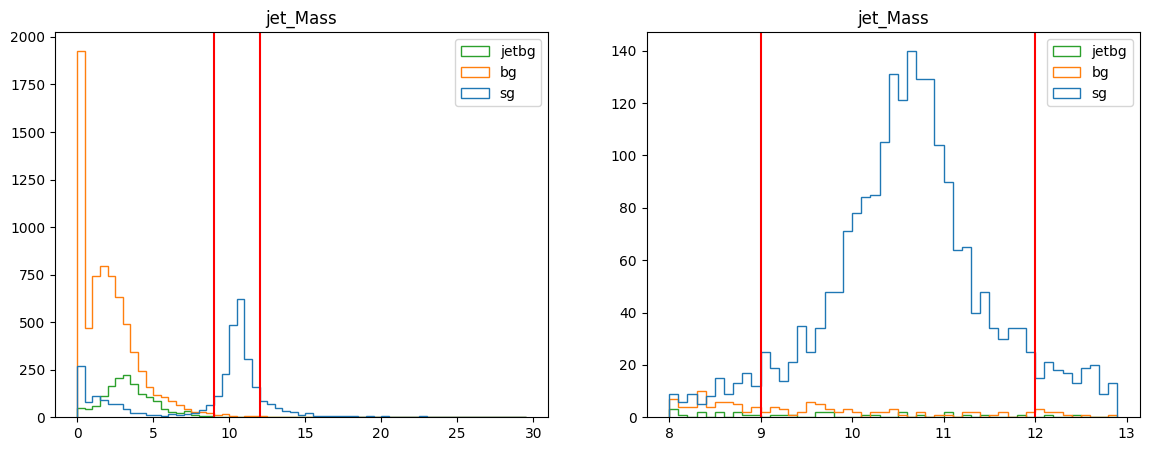

In [8]:
sg_jmass = []
bg_jmass = []
j_jmass = []

sgpic=j_mass(sgsl_1j_Eho_1l,sg_jmass)
bgpic=j_mass(bgsl_1j_Eho_1l,bg_jmass)
jpic=j_mass(jsl_1j_Eho_1l,j_jmass)


plt.figure(1)
plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
bins = np.arange(0,30,0.5)
plt.hist([sg_jmass,bg_jmass,j_jmass],bins=bins,histtype='step',label=['sg','bg','jetbg'])
plt.title(feture[20])
plt.axvline(max_d, color='r')
plt.axvline(max_u, color='r')
plt.legend()
plt.show

plt.subplot(1,2,2)
bins = np.arange(max_d-1,max_u+1,0.1)
plt.hist([sg_jmass,bg_jmass,j_jmass],bins=bins,histtype='step',label=['sg','bg','jetbg'])
plt.title(feture[20])
plt.axvline(max_d, color='r')
plt.axvline(max_u, color='r')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

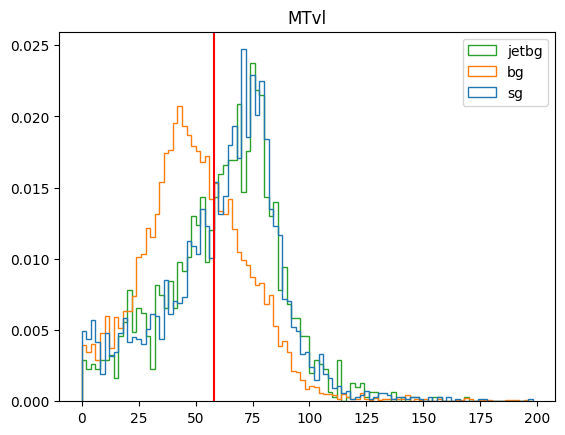

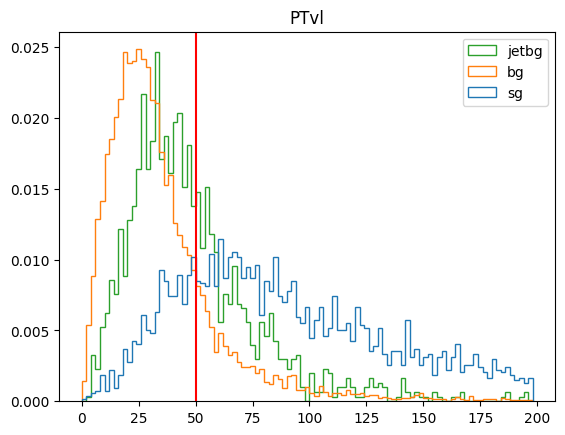

In [9]:
MTv_sgsl_1j_Eho_1l=[]
MTv_bgsl_1j_Eho_1l=[]
MTv_jsl_1j_Eho_1l=[]

PTv_sgsl_1j_Eho_1l=[]
PTv_bgsl_1j_Eho_1l=[]
PTv_jsl_1j_Eho_1l=[]


pica = MTvl_sl(sgsl_1j_Eho_1l,MTv_sgsl_1j_Eho_1l,PTv_sgsl_1j_Eho_1l)
picb = MTvl_sl(bgsl_1j_Eho_1l,MTv_bgsl_1j_Eho_1l,PTv_bgsl_1j_Eho_1l)
picc = MTvl_sl(jsl_1j_Eho_1l,MTv_jsl_1j_Eho_1l,PTv_jsl_1j_Eho_1l)

plt.figure(1)
bins = np.arange(0,200,2)
plt.hist([MTv_sgsl_1j_Eho_1l,MTv_bgsl_1j_Eho_1l,MTv_jsl_1j_Eho_1l],bins=bins,histtype='step',label=['sg','bg','jetbg'],density='ture')
plt.title('MTvl')
plt.axvline(58, color='r')
plt.legend()
plt.show

plt.figure(2)
bins = np.arange(0,200,2)
plt.hist([PTv_sgsl_1j_Eho_1l,PTv_bgsl_1j_Eho_1l,PTv_jsl_1j_Eho_1l],bins=bins,histtype='step',label=['sg','bg','jetbg'],density='ture')
plt.title('PTvl')
plt.axvline(50, color='r')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

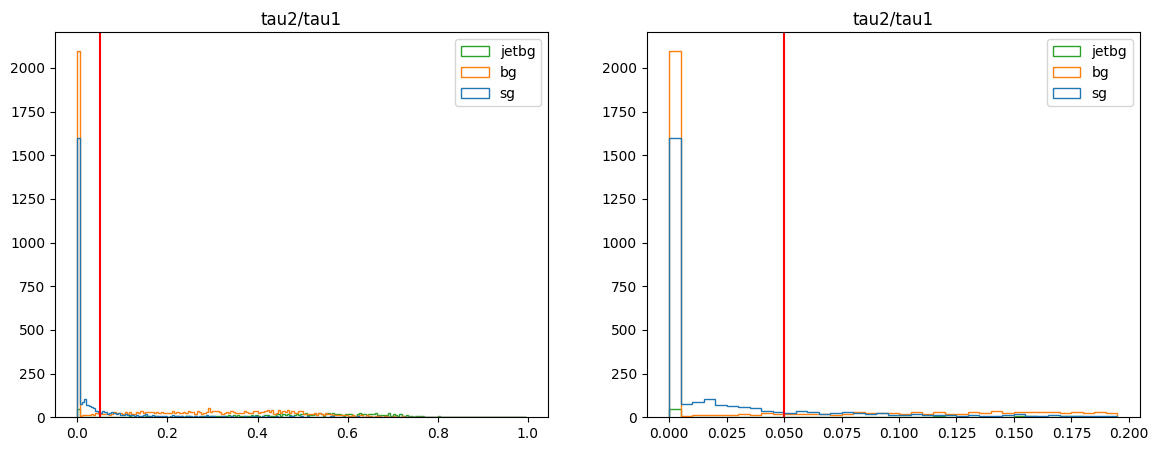

In [10]:
sg_t2ot1 = []
bg_t2ot1 = []
j_t2ot1 = []

draw_tau2overtau1(sgsl_1j_Eho_1l,sg_t2ot1)
draw_tau2overtau1(bgsl_1j_Eho_1l,bg_t2ot1)
draw_tau2overtau1(jsl_1j_Eho_1l,j_t2ot1)


plt.figure(1)
plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
bins = np.arange(0,1,0.005)
plt.hist([sg_t2ot1,bg_t2ot1,j_t2ot1],bins=bins,histtype='step',label=['sg','bg','jetbg'])
plt.title('tau2/tau1')
plt.axvline(0.05, color='r')
plt.legend()
plt.show

plt.subplot(1,2,2)
bins = np.arange(0,0.2,0.005)
plt.hist([sg_t2ot1,bg_t2ot1,j_t2ot1],bins=bins,histtype='step',label=['sg','bg','jetbg'])
plt.title('tau2/tau1')
plt.axvline(0.05, color='r')
plt.legend()
plt.show


In [11]:
sgsl_event = len(sgsl_1j_Eho_1l_jm_PT_MT_t21)
bgsl_event = len(bgsl_1j_Eho_1l_jm_PT_MT_t21)
jsl_event = len(jsl_1j_Eho_1l_jm_PT_MT_t21)

bgNsl_event = len(bg_events)
sgNsl_event = len(sg_events)
jNsl_event = len(j_events)

C_W = 2
C_B = 1
fa = 1000
sin_w_2 = 0.22290
cos_w_2 = 1 - sin_w_2



Lum = [300,3000]
for k in range(len(Lum)):

    s = sg_Xsection*(sgsl_event/sgNsl_event)*Lum[k]
    b1 = bg_Xsection*(bgsl_event/bgNsl_event)*Lum[k]
    b2 = j_Xsection*(jsl_event/jNsl_event)*Lum[k]
    b = b1 + b2

    print('s:',s)
    print('b:',b)

    print('z_short:',significance2(s,b))
    print('z_long:',significance(s,b))
    
    qqq =10000000
    print('s=',qqq,'z=',significance(qqq,b))
    
#    for i in range(0,10000000):
#        if  significance(i,b)-2>0:
#            max_n = i
#            print('near z:',significance(i,b),'i:',i)
#            break

    i = 0
    while True:
        if significance(i, b) - 2 > 0:
            max_n = i
            print('near z:', significance(i, b), 'i:', i)
            break
        i += 1
        
    max_n = max_n        
    min_n = max_n-1

    exp_s = z_2(significance, min_n, max_n,epsilon=1e-5)   #-5   /  -12
    exp_sg_Xsection = (exp_s*sg_Xsection/s)
    
    print('')
    print('\033[0;34mLuminosity:',Lum[k],'\033[0m')
    print('sg_Xsection:',sg_Xsection)
    print('z:',significance(s,b))
    print('exp_z:',significance(exp_s,b))
    print('exp_s:',exp_s)
    print('exp_sg_Xsection:',exp_sg_Xsection)

    fa_limit = fa*np.sqrt(sg_Xsection/exp_sg_Xsection)
    gaww_limt = (4*C_W)/fa_limit

    print('')
    print('fa_limit',fa_limit)
    print('gaww_limt',gaww_limt)
    print('**************************************')



NameError: name 'sgsl_1j_Eho_1l_jm_PT_MT_t21' is not defined

In [ ]:
for i in range (len(jsl_1j_Eho_1l_jm_PT_MT)):
    print(jsl_1j_Eho_1l_jm_PT_MT[i][19])

In [ ]:
print(sgsl_1j[22][20])

In [ ]:
print(np.log(10))
    

In [ ]:
add = [300,3000]
print(add[1])

# 